* Данные: MRI + CONN + patients info (without BDI)

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats

In [3]:
from reskit.core import Pipeliner

In [4]:
conn = pd.read_csv("RESULTS_C_D_E_DE_KONDRATEVA_10.12.csv")
thickness_lh = pd.read_csv("mri_features/th_lh_last.csv", index_col=0)
thickness_rh = pd.read_csv("mri_features/th_rh_last.csv", index_col=0)
thickness = thickness_lh.join(thickness_rh, lsuffix="_lh", rsuffix="_rh")
volumes = pd.read_csv("mri_features/vol_last.csv", index_col=0)
info = pd.read_csv("таблица_10102017.csv", index_col=0, header=1)

target = conn.target
D_target = np.int8(np.logical_or(target == "D", target == "DE"))
E_target = np.int8(np.logical_or(target == "E", target == "DE"))
# 4 classes (С(0), D(1), E(2), DE(3))
DE_target = D_target + E_target * 2

idx = np.argsort(thickness.index)
thickness = thickness.iloc[idx].drop(["target_lh", "target_rh"], axis=1).reset_index(drop=True)
volumes = volumes.iloc[idx].reset_index(drop=True)
conn.drop(["index", "target"], axis=1, inplace=True)
info.reset_index(drop=True, inplace=True)
info["пол (1-мужской, 2- женский)"] -= 1
all_data = info.iloc[:, [1, 2]].join(pd.get_dummies(info.iloc[:, 5], prefix="marital_status")).join(thickness).join(volumes).join(conn)
all_data_nan = pd.DataFrame(all_data.loc[:, all_data.isnull().any(axis=0)].isnull(), dtype=int)
all_data = all_data.join(all_data_nan, rsuffix="_nan")

In [5]:
info.head()

,группа (C - контроль; D - депрессия; DE - эпилепсия с депрессией; E -эпилепсия без депрессии,возраст,"пол (1-мужской, 2- женский)",Длительность психического заболевания(1- < 3 лет; 2- <=3 …< 10 лет; 3- <= 10 лет),данные по шкале BDI-II,"Семейное положение (1-замужем/женат, 2-вдовствует, 3-разведен(а), 4-проживают раздельно; 5-никогда не был(а)",тип эпи приступов (1- фокальные; 2- генерализованные; 3- фокальные со вторичной генерализацией),длительность эпилепсии (1- от 1 года до 3 лет; 2- от 3 до 10 лет; 3- более 10 лет),Частота приступов (1 -редкие (не чаще 1 в год) или ремиссия; 2 - средней частоты (2раза/год ≤ частота < 1 раз/месяц); 3 - частые (чаще 1/мес),дебют эпилепсии (1- детский возраст (0 до 11 лет; 2-подростковый (12 до 18 лет); 3- взрослый (старше 18),локализация очага (1 - височная доля; 2 -лобная доля; 3- другая (теменная или затылочная); 4- генерализованные приступы; 5- неизвестно),латерализация очага (1-слева; 2 -справа; 3 -билатерально; 4- неизвестно)
0,E,29,0,NaN,4,5,1,2.0,3.0,2,"1,2",3.0
1,DE,38,1,1.0,12,1,3,1.0,3.0,2,2,1.0
2,E,28,0,NaN,6,1,"1,3",2.0,1.0,3,"1,3",1.0
3,D,33,1,2.0,11,1,NaN,NaN,NaN,NaN,NaN,NaN
4,E,18,0,NaN,8,5,3,2.0,3.0,3,2,4.0


In [6]:
all_data.head()

,возраст,"пол (1-мужской, 2- женский)",marital_status_1,marital_status_2,marital_status_3,marital_status_4,marital_status_5,bankssts_NumVert_lh,caudalanteriorcingulate_NumVert_lh,caudalmiddlefrontal_NumVert_lh,...,AveragePathLength.151_nan,ClusteringCoefficient.151_nan,LocalEfficiency.152_nan,ClusteringCoefficient.152_nan,LocalEfficiency.163_nan,AveragePathLength.163_nan,ClusteringCoefficient.163_nan,LocalEfficiency.164_nan,AveragePathLength.164_nan,ClusteringCoefficient.164_nan
0,29,0,0,0,0,0,1,1794,1030,3395,...,0,0,0,0,0,0,0,0,0,0
1,38,1,1,0,0,0,0,1893,1117,4504,...,0,0,0,0,0,0,0,0,0,0
2,28,0,1,0,0,0,0,1089,900,2295,...,0,0,0,0,0,0,0,0,0,0
3,33,1,1,0,0,0,0,1624,1755,3126,...,0,0,0,0,0,0,0,0,0,0
4,18,0,0,0,0,0,1,1377,1186,4497,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# отбор признаков на основе модели
# аналогично SelectFromModel, но на основе количества признаков, а не порога

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectNFeaturesFromModel(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    def __init__(self, estimator, n_selected, prefit=False):
        self.estimator = estimator
        self.n_selected = n_selected
        self.prefit = prefit

    def _get_support_mask(self):
        if self.prefit:
            estimator = self.estimator
        elif hasattr(self, 'estimator_'):
            estimator = self.estimator_
        else:
            raise ValueError(
                'Either fit SelectFromModel before transform or set "prefit='
                'True" and pass a fitted estimator to the constructor.')
        scores = _get_feature_importances(estimator)
        threshold = np.sort(scores)[-self.n_selected]
        return scores >= threshold

    def fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)
        return self

    @property
    def threshold_(self):
        scores = _get_feature_importances(self.estimator_, self.norm_order)
        return np.sort(scores)[-n_selected]
    
    @if_delegate_has_method('estimator')
    def partial_fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        if not hasattr(self, "estimator_"):
            self.estimator_ = clone(self.estimator)
        self.estimator_.partial_fit(X, y, **fit_params)
        return self

In [8]:
def plot_results(n_features, clf_results, ax, color="tab:blue", label=None, alpha=0.1):
    clf_res = clf_results.groupby("classifier").eval_accuracy_mean.groups

    ax.plot(n_features, np.float32(clf_results.loc[:, "eval_accuracy_mean"]), color=color, label=label)
    ax.axis(ymin=0.0, ymax=1.0)
    upper = np.float32(clf_results.loc[:, "eval_accuracy_mean"] + clf_results.loc[:, "eval_accuracy_std"])
    lower = np.float32(clf_results.loc[:, "eval_accuracy_mean"] - clf_results.loc[:, "eval_accuracy_std"])
    ax.fill_between(n_features, upper, lower, color=color, alpha=alpha)

In [9]:
def validate(X, y, pipeline, test_size, random_state_scores=[42, 0, 60, 72, 76, 82, 7, 9, 765, 654]):
    scores = []
    for s in tqdm(random_state_scores):
        sss = StratifiedShuffleSplit(n_splits=10, test_size=test_size, random_state=s)
        for train_idx, test_idx in sss.split(X, y):
            pipeline.fit(X.iloc[train_idx], y[train_idx])
            scores.append(pipeline.score(X.iloc[test_idx], y[test_idx]))
    return scores

100%|██████████| 5/5 [05:18<00:00, 63.78s/it]


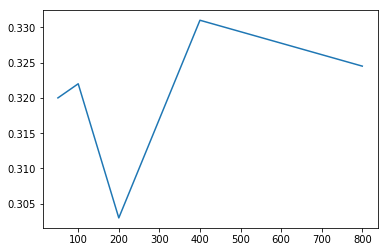

In [10]:
# ориентировочная зависимость accuracy RFC от n_estimators
X, y = all_data, DE_target
n_estimators_l = [50 * 2 ** i for i in range(5)]
scores = []
for n_estimators in tqdm(n_estimators_l):
    pipe = Pipeline([
    ('FillMedian', Imputer(strategy="median")),
#     ('StdScaler', StandardScaler()),
    ("VarTh", VarianceThreshold()),
    ('RFC', RandomForestClassifier(n_estimators=n_estimators))
                     ])
    scores.append(np.mean(cross_val_score(pipe, X, y, scoring="accuracy", cv=RepeatedStratifiedKFold(n_repeats=20, n_splits=5))))
plt.plot(n_estimators_l, scores)

100%|██████████| 6/6 [07:36<00:00, 76.17s/it]


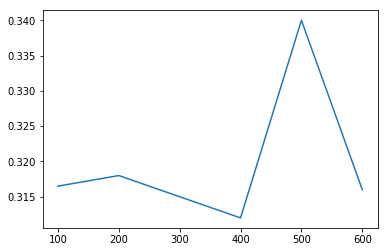

In [11]:
# ориентировочная зависимость accuracy RFC от n_estimators
X, y = all_data, DE_target
n_estimators_l = [i for i in range(100, 700, 100)]
scores = []
for n_estimators in tqdm(n_estimators_l):
    pipe = Pipeline([
    ('FillMedian', Imputer(strategy="median")),
#     ('StdScaler', StandardScaler()),
    ("VarTh", VarianceThreshold()),
    ('RFC', RandomForestClassifier(n_estimators=n_estimators))
                     ])
    scores.append(np.mean(cross_val_score(pipe, X, y, scoring="accuracy", cv=RepeatedStratifiedKFold(n_repeats=20, n_splits=5))))
plt.plot(n_estimators_l, scores)

In [13]:
n_features = [2 ** i for i in range(1, 9)]

def get_pipelines(n_splits):
    preprocessing = [("Fill_Median", Imputer(strategy="median"))]
    preprocessing2 = [('StdScaler', StandardScaler())]
    feature_selection = [("VarTh", VarianceThreshold())]
    
    feature_engineering_ttest = [("ttest_" + str(i), SelectKBest(stats.ttest_ind, i)) for i in n_features]
    feature_engineering_f = [("f_" + str(i), SelectKBest(f_classif, i)) for i in n_features]
    feature_engineering_rfc = [("rfc_" + str(i), SelectNFeaturesFromModel(RandomForestClassifier(n_estimators=100, random_state=42), 
                                                                     n_selected=i)) for i in n_features]
    feature_engineering_lr = [("lr_" + str(i), SelectNFeaturesFromModel(LogisticRegression(), 
                                                                     n_selected=i)) for i in n_features]
    
    classifiers = [('RFC', RandomForestClassifier(n_estimators=300))]
    
    steps_ttest = [('preprocessing', preprocessing),
             ('preprocessing2', preprocessing2),
             ('feature_selection', feature_selection),
             ('feature_engineering', feature_engineering_ttest),
             ('classifier', classifiers)]
    steps_f = [('preprocessing', preprocessing),
             ('preprocessing2', preprocessing2),
             ('feature_selection', feature_selection),
             ('feature_engineering', feature_engineering_f),
             ('classifier', classifiers)]
    steps_rfc = [('preprocessing', preprocessing),
             ('preprocessing2', preprocessing2),
             ('feature_selection', feature_selection),
             ('feature_engineering', feature_engineering_rfc),
             ('classifier', classifiers)]
    steps_lr = [('preprocessing', preprocessing),
             ('preprocessing2', preprocessing2),
             ('feature_selection', feature_selection),
             ('feature_engineering', feature_engineering_lr),
             ('classifier', classifiers)]
    
#     param_grid = {'RFC': {
#         'kernel': ['linear', 'rbf'],
#         'C': [10 ** i for i in range(-1, 4)],
#         'gamma': [10 ** i for i in range(-3, 2)],
#     }}
    
    grid_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=100 // n_splits, random_state=2)
    eval_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=100 // n_splits, random_state=42)

    pipe_ttest = Pipeliner(steps=steps_ttest, 
#                      param_grid=param_grid,
                     grid_cv=None, 
                     eval_cv=eval_cv)
    pipe_f = Pipeliner(steps=steps_f,
#                  param_grid=param_grid,
                 grid_cv=None, 
                 eval_cv=eval_cv)
    pipe_rfc = Pipeliner(steps=steps_rfc,
#                  param_grid=param_grid,
                 grid_cv=None, 
                 eval_cv=eval_cv)
    pipe_lr = Pipeliner(steps=steps_lr,
#                  param_grid=param_grid,
                 grid_cv=None,  
                 eval_cv=eval_cv)
    return pipe_ttest, pipe_f, pipe_rfc, pipe_lr

In [14]:
# 4 classes
X, y = all_data, DE_target

In [15]:
pipe_ttest, pipe_f, pipe_rfc, pipe_lr = get_pipelines(n_splits=5)
start_time = time.time()
DE_ttest_results = pipe_ttest.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
DE_f_results = pipe_f.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
DE_rfc_results = pipe_rfc.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
DE_lr_results = pipe_lr.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")

Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
244.41281151771545 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
298.11442708969116 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
400.2027223110199 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
499.22827672958374 s


In [17]:
DE_ttest_results.to_csv("all_data_rfc/DE_ttest_nan_hp_results.csv")
DE_f_results.to_csv("all_data_rfc/DE_f_nan_hp_results.csv")
DE_rfc_results.to_csv("all_data_rfc/DE_rfc_hp_nan_results.csv")
DE_lr_results.to_csv("all_data_rfc/DE_lr_nan_hp_results.csv")

# DE_ttest_results = pd.read_csv("all_data_rfc/DE_ttest_nan_hp_results.csv", index_col=0)
# DE_f_results = pd.read_csv("all_data_rfc/DE_f_nan_hp_results.csv", index_col=0)
# DE_rfc_results = pd.read_csv("all_data_rfc/DE_rfc_nan_hp_results.csv", index_col=0)
# DE_lr_results = pd.read_csv("all_data_rfc/DE_lr_nan_hp_results.csv", index_col=0)

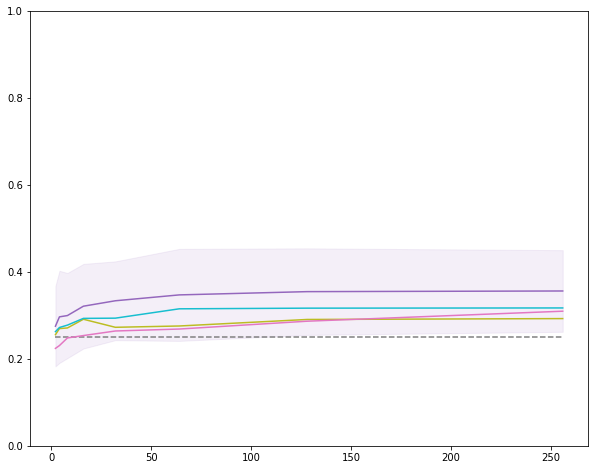

In [42]:
f, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_features, np.full_like(n_features, 0.25, dtype=np.float64), color='tab:gray', linestyle='dashed')
plot_results(n_features=n_features, clf_results=DE_ttest_results, ax=ax, color='tab:purple', alpha=0.1)
plot_results(n_features=n_features, clf_results=DE_f_results, ax=ax, color='tab:olive', alpha=0)
plot_results(n_features=n_features, clf_results=DE_rfc_results, ax=ax, color='tab:cyan', alpha=0)
plot_results(n_features=n_features, clf_results=DE_lr_results, ax=ax, color='tab:pink', alpha=0)

In [19]:
DE_ttest_results

,preprocessing,preprocessing2,feature_selection,feature_engineering,classifier,grid_accuracy_mean,grid_accuracy_std,grid_accuracy_best_params,eval_accuracy_mean,eval_accuracy_std,eval_accuracy_scores
0,Fill_Median,StdScaler,VarTh,ttest_2,RFC,NaN,NaN,NaN,0.275,0.0923309,[ 0.25 0.2 0.25 0.05 0.35 0.35 0.15 0....
1,Fill_Median,StdScaler,VarTh,ttest_4,RFC,NaN,NaN,NaN,0.2965,0.10589,[ 0.2 0.15 0.2 0.2 0.45 0.35 0.3 0....
2,Fill_Median,StdScaler,VarTh,ttest_8,RFC,NaN,NaN,NaN,0.2995,0.0978507,[ 0.25 0.2 0.2 0.2 0.35 0.4 0.35 0....
3,Fill_Median,StdScaler,VarTh,ttest_16,RFC,NaN,NaN,NaN,0.321,0.0972574,[ 0.25 0.35 0.3 0.2 0.25 0.35 0.25 0....
4,Fill_Median,StdScaler,VarTh,ttest_32,RFC,NaN,NaN,NaN,0.3335,0.090569,[ 0.3 0.45 0.45 0.35 0.3 0.45 0.4 0....
5,Fill_Median,StdScaler,VarTh,ttest_64,RFC,NaN,NaN,NaN,0.347,0.105788,[ 0.3 0.4 0.45 0.3 0.35 0.35 0.4 0....
6,Fill_Median,StdScaler,VarTh,ttest_128,RFC,NaN,NaN,NaN,0.3545,0.0995226,[ 0.4 0.4 0.2 0.25 0.35 0.3 0.35 0....
7,Fill_Median,StdScaler,VarTh,ttest_256,RFC,NaN,NaN,NaN,0.356,0.0938829,[ 0.3 0.3 0.45 0.3 0.35 0.35 0.35 0....


In [20]:
# E(50)/no Epilepsy(50)
X, y = all_data, E_target

In [21]:
pipe_ttest, pipe_f, pipe_rfc, pipe_lr = get_pipelines(n_splits=10)
start_time = time.time()
E_ttest_results = pipe_ttest.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
E_f_results = pipe_f.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
E_rfc_results = pipe_rfc.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
E_lr_results = pipe_lr.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")

Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
224.2432074546814 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
279.34917283058167 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
389.32877469062805 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
310.82875752449036 s


In [22]:
E_ttest_results.to_csv("all_data_rfc/E_ttest_nan_hp_results.csv")
E_f_results.to_csv("all_data_rfc/E_f_nan_hp_results.csv")
E_rfc_results.to_csv("all_data_rfc/E_rfc_nan_hp_results.csv")
E_lr_results.to_csv("all_data_rfc/E_lr_nan_hp_results.csv")

# E_ttest_results = pd.read_csv("all_data_rfc/E_ttest_nan_hp_results.csv", index_col=0)
# E_f_results = pd.read_csv("all_data_rfc/E_f_nan_hp_results.csv", index_col=0)
# E_rfc_results = pd.read_csv("all_data_rfc/E_rfc_nan_hp_results.csv", index_col=0)
# E_lr_results = pd.read_csv("all_data_rfc/E_lr_nan_hp_results.csv", index_col=0)

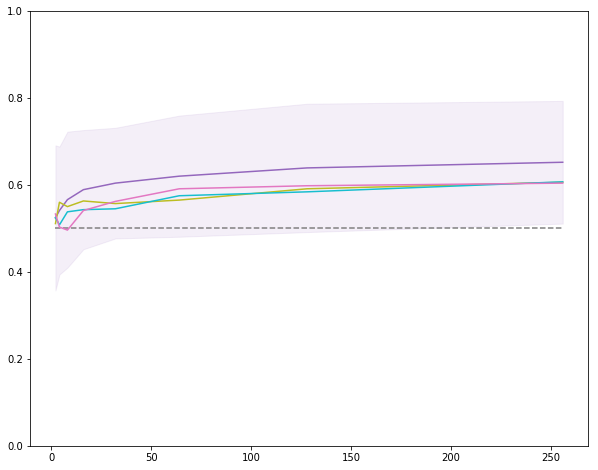

In [43]:
f, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_features, np.full_like(n_features, 0.5, dtype=np.float64), color='tab:gray', linestyle='dashed')
plot_results(n_features=n_features, clf_results=E_ttest_results, ax=ax, color='tab:purple', alpha=0.1)
plot_results(n_features=n_features, clf_results=E_f_results, ax=ax, color='tab:olive', alpha=0)
plot_results(n_features=n_features, clf_results=E_rfc_results, ax=ax, color='tab:cyan', alpha=0)
plot_results(n_features=n_features, clf_results=E_lr_results, ax=ax, color='tab:pink', alpha=0)

In [24]:
E_ttest_results

,preprocessing,preprocessing2,feature_selection,feature_engineering,classifier,grid_accuracy_mean,grid_accuracy_std,grid_accuracy_best_params,eval_accuracy_mean,eval_accuracy_std,eval_accuracy_scores
0,Fill_Median,StdScaler,VarTh,ttest_2,RFC,NaN,NaN,NaN,0.524,0.166805,[ 0.7 0.4 0.4 0.4 0.6 0.6 0.4 0.5 0.6 ...
1,Fill_Median,StdScaler,VarTh,ttest_4,RFC,NaN,NaN,NaN,0.541,0.147034,[ 0.6 0.5 0.4 0.7 0.7 0.7 0.5 0.4 0.6 ...
2,Fill_Median,StdScaler,VarTh,ttest_8,RFC,NaN,NaN,NaN,0.566,0.156346,[ 0.5 0.6 0.7 0.6 0.6 0.8 0.6 0.8 0.6 ...
3,Fill_Median,StdScaler,VarTh,ttest_16,RFC,NaN,NaN,NaN,0.589,0.137036,[ 0.6 0.9 0.5 0.6 0.3 0.6 0.7 0.7 0.6 ...
4,Fill_Median,StdScaler,VarTh,ttest_32,RFC,NaN,NaN,NaN,0.604,0.127216,[ 0.6 0.7 0.5 0.5 0.5 0.6 0.7 0.7 0.6 ...
5,Fill_Median,StdScaler,VarTh,ttest_64,RFC,NaN,NaN,NaN,0.62,0.139284,[ 0.6 0.6 0.5 0.6 0.5 0.6 0.6 0.7 0.5 ...
6,Fill_Median,StdScaler,VarTh,ttest_128,RFC,NaN,NaN,NaN,0.639,0.147577,[ 0.6 0.6 0.5 0.5 0.6 0.6 0.6 0.7 0.5 ...
7,Fill_Median,StdScaler,VarTh,ttest_256,RFC,NaN,NaN,NaN,0.652,0.141053,[ 0.6 0.7 0.5 0.5 0.9 0.7 0.9 0.7 0.5 ...


In [25]:
# D(50)/no Depression(50)
X, y = all_data, D_target

In [26]:
pipe_ttest, pipe_f, pipe_rfc, pipe_lr = get_pipelines(n_splits=10)
start_time = time.time()
D_ttest_results = pipe_ttest.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
D_f_results = pipe_f.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
D_rfc_results = pipe_rfc.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
D_lr_results = pipe_lr.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")

Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
199.45952725410461 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
206.6182894706726 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
380.23709869384766 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
291.35100388526917 s


In [27]:
D_ttest_results.to_csv("all_data_rfc/D_ttest_nan_hp_results.csv")
D_f_results.to_csv("all_data_rfc/D_f_nan_hp_results.csv")
D_rfc_results.to_csv("all_data_rfc/D_rfc_nan_hp_results.csv")
D_lr_results.to_csv("all_data_rfc/D_lr_nan_hp_results.csv")

# D_ttest_results = pd.read_csv("all_data_rfc/D_ttest_nan_hp_results.csv", index_col=0)
# D_f_results = pd.read_csv("all_data_rfc/D_f_nan_hp_results.csv", index_col=0)
# D_rfc_results = pd.read_csv("all_data_rfc/D_rfc_nan_hp_results.csv", index_col=0)
# D_lr_results = pd.read_csv("all_data_rfc/D_lr_nan_hp_results.csv", index_col=0)

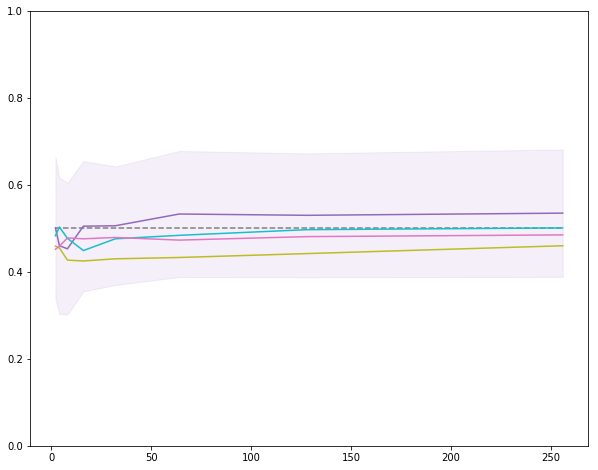

In [44]:
f, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_features, np.full_like(n_features, 0.5, dtype=np.float64), color='tab:gray', linestyle='dashed')
plot_results(n_features=n_features, clf_results=D_ttest_results, ax=ax, color='tab:purple', alpha=0.1)
plot_results(n_features=n_features, clf_results=D_f_results, ax=ax, color='tab:olive', alpha=0)
plot_results(n_features=n_features, clf_results=D_rfc_results, ax=ax, color='tab:cyan', alpha=0)
plot_results(n_features=n_features, clf_results=D_lr_results, ax=ax, color='tab:pink', alpha=0)

In [29]:
D_ttest_results

,preprocessing,preprocessing2,feature_selection,feature_engineering,classifier,grid_accuracy_mean,grid_accuracy_std,grid_accuracy_best_params,eval_accuracy_mean,eval_accuracy_std,eval_accuracy_scores
0,Fill_Median,StdScaler,VarTh,ttest_2,RFC,NaN,NaN,NaN,0.501,0.162785,[ 0.3 0.2 0.5 0.5 0.6 0.8 0.5 0.5 0.5 ...
1,Fill_Median,StdScaler,VarTh,ttest_4,RFC,NaN,NaN,NaN,0.46,0.156844,[ 0.5 0.2 0.2 0.7 0.5 0.7 0.4 0.5 0.4 ...
2,Fill_Median,StdScaler,VarTh,ttest_8,RFC,NaN,NaN,NaN,0.453,0.151298,[ 0.6 0.3 0.4 0.6 0.5 0.7 0.5 0.5 0.4 ...
3,Fill_Median,StdScaler,VarTh,ttest_16,RFC,NaN,NaN,NaN,0.505,0.149917,[ 0.8 0.3 0.7 0.5 0.4 0.7 0.6 0.5 0.3 ...
4,Fill_Median,StdScaler,VarTh,ttest_32,RFC,NaN,NaN,NaN,0.506,0.13625,[ 0.8 0.4 0.6 0.7 0.4 0.6 0.7 0.5 0.3 ...
5,Fill_Median,StdScaler,VarTh,ttest_64,RFC,NaN,NaN,NaN,0.533,0.144952,[ 0.7 0.2 0.5 0.5 0.5 0.7 0.5 0.6 0.5 ...
6,Fill_Median,StdScaler,VarTh,ttest_128,RFC,NaN,NaN,NaN,0.53,0.142478,[ 0.9 0.6 0.5 0.5 0.4 0.6 0.4 0.5 0.4 ...
7,Fill_Median,StdScaler,VarTh,ttest_256,RFC,NaN,NaN,NaN,0.535,0.146544,[ 0.6 0.3 0.5 0.5 0.5 0.6 0.4 0.5 0.5 ...


In [30]:
# E(25)/ Control(25)
idx = np.logical_or(target == "E", target == "С") # "C" - rus
X, y = all_data[idx], E_target[idx]
pipe_ttest, pipe_f, pipe_rfc, pipe_lr = get_pipelines(n_splits=5)

start_time = time.time()
EC_ttest_results = pipe_ttest.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
EC_f_results = pipe_f.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
EC_rfc_results = pipe_rfc.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
EC_lr_results = pipe_lr.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")

Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
183.0250949859619 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
229.12592601776123 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
342.82674503326416 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
255.10570359230042 s


In [31]:
EC_ttest_results.to_csv("all_data_rfc/EC_ttest_nan_hp_results.csv")
EC_f_results.to_csv("all_data_rfc/EC_f_nan_hp_results.csv")
EC_rfc_results.to_csv("all_data_rfc/EC_rfc_nan_hp_results.csv")
EC_lr_results.to_csv("all_data_rfc/EC_lr_nan_hp_results.csv")

# EC_ttest_results = pd.read_csv("all_data_rfc/EC_ttest_nan_hp_results.csv", index_col=0)
# EC_f_results = pd.read_csv("all_data_rfc/EC_f_nan_hp_results.csv", index_col=0)
# EC_rfc_results = pd.read_csv("all_data_rfc/EC_rfc_nan_hp_results.csv", index_col=0)
# EC_lr_results = pd.read_csv("all_data_rfc/EC_lr_nan_hp_results.csv", index_col=0)

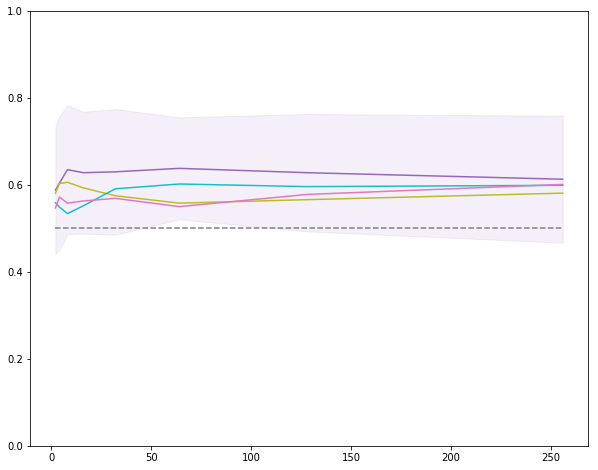

In [45]:
f, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_features, np.full_like(n_features, 0.5, dtype=np.float64), color='tab:gray', linestyle='dashed')
plot_results(n_features=n_features, clf_results=EC_ttest_results, ax=ax, color='tab:purple', alpha=0.1)
plot_results(n_features=n_features, clf_results=EC_f_results, ax=ax, color='tab:olive', alpha=0)
plot_results(n_features=n_features, clf_results=EC_rfc_results, ax=ax, color='tab:cyan', alpha=0)
plot_results(n_features=n_features, clf_results=EC_lr_results, ax=ax, color='tab:pink', alpha=0)

In [33]:
EC_ttest_results

,preprocessing,preprocessing2,feature_selection,feature_engineering,classifier,grid_accuracy_mean,grid_accuracy_std,grid_accuracy_best_params,eval_accuracy_mean,eval_accuracy_std,eval_accuracy_scores
0,Fill_Median,StdScaler,VarTh,ttest_2,RFC,NaN,NaN,NaN,0.588,0.146479,[ 0.5 0.6 0.4 0.8 0.5 0.6 0.4 0.6 0.3 ...
1,Fill_Median,StdScaler,VarTh,ttest_4,RFC,NaN,NaN,NaN,0.604,0.152918,[ 0.4 0.6 0.5 0.8 0.7 0.3 0.7 0.6 0.6 ...
2,Fill_Median,StdScaler,VarTh,ttest_8,RFC,NaN,NaN,NaN,0.635,0.148577,[ 0.5 0.6 0.5 0.5 0.6 0.5 0.6 0.6 0.6 ...
3,Fill_Median,StdScaler,VarTh,ttest_16,RFC,NaN,NaN,NaN,0.628,0.140057,[ 0.3 0.5 0.4 0.5 0.6 0.4 0.8 0.6 0.7 ...
4,Fill_Median,StdScaler,VarTh,ttest_32,RFC,NaN,NaN,NaN,0.63,0.144568,[ 0.6 0.7 0.7 0.9 0.7 0.5 0.7 0.7 0.8 ...
5,Fill_Median,StdScaler,VarTh,ttest_64,RFC,NaN,NaN,NaN,0.638,0.117286,[ 0.7 0.6 0.6 0.8 0.6 0.5 0.7 0.5 0.5 ...
6,Fill_Median,StdScaler,VarTh,ttest_128,RFC,NaN,NaN,NaN,0.628,0.134967,[ 0.6 0.7 0.4 0.7 0.4 0.5 0.6 0.7 0.7 ...
7,Fill_Median,StdScaler,VarTh,ttest_256,RFC,NaN,NaN,NaN,0.613,0.146051,[ 0.6 0.8 0.5 0.7 0.5 0.5 0.6 0.5 0.8 ...


In [34]:
# D(25)/ Control (25)
idx = np.logical_or(target == "D", target == "С") # "C" - rus
X, y = all_data[idx], D_target[idx]
pipe_ttest, pipe_f, pipe_rfc, pipe_lr = get_pipelines(n_splits=5)

start_time = time.time()
DC_ttest_results = pipe_ttest.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
DC_f_results = pipe_f.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
DC_rfc_results = pipe_rfc.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
DC_lr_results = pipe_lr.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")

Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
198.97783184051514 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
248.40209126472473 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
338.209486246109 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
260.8611068725586 s


In [35]:
DC_ttest_results.to_csv("all_data_rfc/DC_ttest_nan_hp_results.csv")
DC_f_results.to_csv("all_data_rfc/DC_f_nan_hp_results.csv")
DC_rfc_results.to_csv("all_data_rfc/DC_rfc_nan_hp_results.csv")
DC_lr_results.to_csv("all_data_rfc/DC_lr_nan_hp_results.csv")

# DC_ttest_results = pd.read_csv("all_data_rfc/DC_ttest_nan_hp_results.csv", index_col=0)
# DC_f_results = pd.read_csv("all_data_rfc/DC_f_nan_hp_results.csv", index_col=0)
# DC_rfc_results = pd.read_csv("all_data_rfc/DC_rfc_nan_hp_results.csv", index_col=0)
# DC_lr_results = pd.read_csv("all_data_rfc/DC_lr_nan_hp_results.csv", index_col=0)

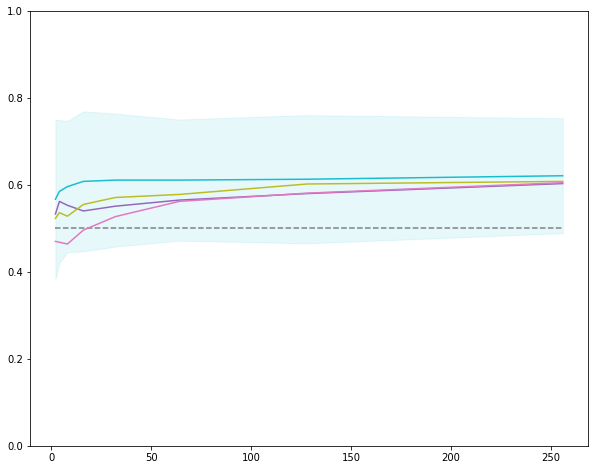

In [46]:
f, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_features, np.full_like(n_features, 0.5, dtype=np.float64), color='tab:gray', linestyle='dashed')
plot_results(n_features=n_features, clf_results=DC_ttest_results, ax=ax, color='tab:purple', alpha=0)
plot_results(n_features=n_features, clf_results=DC_f_results, ax=ax, color='tab:olive', alpha=0)
plot_results(n_features=n_features, clf_results=DC_rfc_results, ax=ax, color='tab:cyan', alpha=0.1)
plot_results(n_features=n_features, clf_results=DC_lr_results, ax=ax, color='tab:pink', alpha=0)

In [37]:
DC_rfc_results

,preprocessing,preprocessing2,feature_selection,feature_engineering,classifier,grid_accuracy_mean,grid_accuracy_std,grid_accuracy_best_params,eval_accuracy_mean,eval_accuracy_std,eval_accuracy_scores
0,Fill_Median,StdScaler,VarTh,rfc_2,RFC,NaN,NaN,NaN,0.567,0.183333,[ 0.6 0.6 0.4 0.5 0.5 0.8 0.5 0.8 0.4 ...
1,Fill_Median,StdScaler,VarTh,rfc_4,RFC,NaN,NaN,NaN,0.585,0.163936,[ 0.4 0.6 0.6 0.6 0.9 0.7 0.3 0.7 0.5 ...
2,Fill_Median,StdScaler,VarTh,rfc_8,RFC,NaN,NaN,NaN,0.596,0.150944,[ 0.3 0.8 0.5 0.5 0.8 0.7 0.2 0.7 0.5 ...
3,Fill_Median,StdScaler,VarTh,rfc_16,RFC,NaN,NaN,NaN,0.608,0.161047,[ 0.3 0.6 0.8 0.3 0.7 0.7 0.4 0.8 0.5 ...
4,Fill_Median,StdScaler,VarTh,rfc_32,RFC,NaN,NaN,NaN,0.611,0.152902,[ 0.3 0.5 0.6 0.5 0.7 0.7 0.4 0.9 0.6 ...
5,Fill_Median,StdScaler,VarTh,rfc_64,RFC,NaN,NaN,NaN,0.611,0.139208,[ 0.4 0.5 0.5 0.6 0.6 0.8 0.4 0.7 0.6 ...
6,Fill_Median,StdScaler,VarTh,rfc_128,RFC,NaN,NaN,NaN,0.613,0.147414,[ 0.3 0.7 0.5 0.6 0.7 0.7 0.4 0.6 0.5 ...
7,Fill_Median,StdScaler,VarTh,rfc_256,RFC,NaN,NaN,NaN,0.621,0.132133,[ 0.4 0.7 0.7 0.6 0.7 0.7 0.4 0.7 0.7 ...


In [38]:
# DE(25)/E(25)
idx = np.logical_or(target == "DE", target == "E")
X, y = all_data[idx], D_target[idx]
pipe_ttest, pipe_f, pipe_rfc, pipe_lr = get_pipelines(n_splits=5)

start_time = time.time()
DEE_ttest_results = pipe_ttest.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
DEE_f_results = pipe_f.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
DEE_rfc_results = pipe_rfc.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")
start_time = time.time()
DEE_lr_results = pipe_lr.get_results(X, y, scoring=["accuracy"])
print(time.time() - start_time, "s")

Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
210.09659051895142 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
246.37204217910767 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
341.1018605232239 s
Line: 1/8
Line: 2/8
Line: 3/8
Line: 4/8
Line: 5/8
Line: 6/8
Line: 7/8
Line: 8/8
264.26567029953003 s


In [39]:
DEE_ttest_results.to_csv("all_data_rfc/DEE_ttest_nan_hp_results.csv")
DEE_f_results.to_csv("all_data_rfc/DEE_f_nan_hp_results.csv")
DEE_rfc_results.to_csv("all_data_rfc/DEE_rfc_nan_hp_results.csv")
DEE_lr_results.to_csv("all_data_rfc/DEE_lr_nan_hp_results.csv")

# DEE_ttest_results = pd.read_csv("all_data_rfc/DEE_ttest_nan_hp_results.csv", index_col=0)
# DEE_f_results = pd.read_csv("all_data_rfc/DEE_f_nan_hp_results.csv", index_col=0)
# DEE_rfc_results = pd.read_csv("all_data_rfc/DEE_rfc_nan_hp_results.csv", index_col=0)
# DEE_lr_results = pd.read_csv("all_data_rfc/DEE_lr_nan_hp_results.csv", index_col=0)

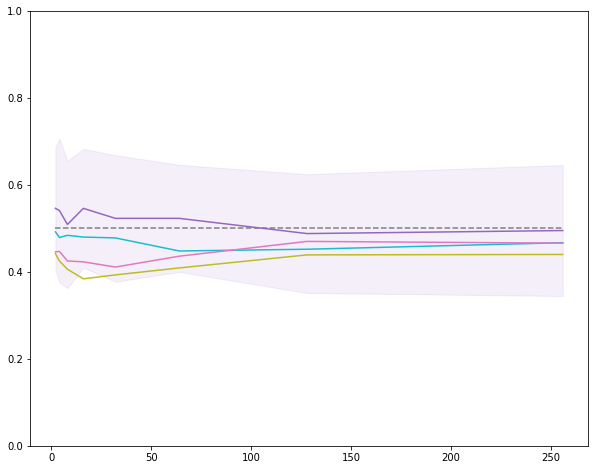

In [47]:
f, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_features, np.full_like(n_features, 0.5, dtype=np.float64), color='tab:gray', linestyle='dashed')
plot_results(n_features=n_features, clf_results=DEE_ttest_results, ax=ax, color='tab:purple', alpha=0.1)
plot_results(n_features=n_features, clf_results=DEE_f_results, ax=ax, color='tab:olive', alpha=0)
plot_results(n_features=n_features, clf_results=DEE_rfc_results, ax=ax, color='tab:cyan', alpha=0)
plot_results(n_features=n_features, clf_results=DEE_lr_results, ax=ax, color='tab:pink', alpha=0)

In [41]:
DEE_ttest_results

,preprocessing,preprocessing2,feature_selection,feature_engineering,classifier,grid_accuracy_mean,grid_accuracy_std,grid_accuracy_best_params,eval_accuracy_mean,eval_accuracy_std,eval_accuracy_scores
0,Fill_Median,StdScaler,VarTh,ttest_2,RFC,NaN,NaN,NaN,0.546,0.141011,[ 0.4 0.5 0.6 0.6 0.5 0.6 0.5 0.4 0.6 ...
1,Fill_Median,StdScaler,VarTh,ttest_4,RFC,NaN,NaN,NaN,0.541,0.165587,[ 0.3 0.5 0.5 0.6 0.7 0.4 0.7 0.6 0.6 ...
2,Fill_Median,StdScaler,VarTh,ttest_8,RFC,NaN,NaN,NaN,0.509,0.146352,[ 0.6 0.5 0.4 0.7 0.8 0.4 0.5 0.8 0.4 ...
3,Fill_Median,StdScaler,VarTh,ttest_16,RFC,NaN,NaN,NaN,0.546,0.136689,[ 0.4 0.7 0.6 0.4 0.7 0.5 0.4 0.8 0.7 ...
4,Fill_Median,StdScaler,VarTh,ttest_32,RFC,NaN,NaN,NaN,0.523,0.145503,[ 0.5 0.7 0.5 0.5 0.8 0.4 0.6 0.4 0.7 ...
5,Fill_Median,StdScaler,VarTh,ttest_64,RFC,NaN,NaN,NaN,0.523,0.123171,[ 0.3 0.7 0.5 0.4 0.7 0.4 0.6 0.5 0.4 ...
6,Fill_Median,StdScaler,VarTh,ttest_128,RFC,NaN,NaN,NaN,0.488,0.136587,[ 0.5 0.6 0.5 0.7 0.6 0.2 0.2 0.5 0.4 ...
7,Fill_Median,StdScaler,VarTh,ttest_256,RFC,NaN,NaN,NaN,0.495,0.150582,[ 0.5 0.5 0.4 0.5 0.6 0.3 0.3 0.5 0.3 ...
